In [3]:
import numpy as np
import matplotlib.pyplot as plt
from IterativePricing import IterativePricing
from plot_B import plot_B


In this project, I will analyze and reproduce the method purposed in the paper A Simple Iterative Method for the Valuation of American Options. The method was derived from the Black-Scholes model and Little et al. (2000)’s idea of representing the value of American option (put) with European option value and a single integral involving the exercise boundary. By estimating the Exercise Boundary using iterative numerical method, the option value can be easily calculated. 

## Initialize IterativePricing object

The IterativePricing class is written for solving the American Put Option value. In this example, we let risk-free interest rate r = 0.05, volatility of the underlying asset $\sigma$ = 0.2, strike price K = 45, and maturity time T = 0.5 year. You can see details at IterativePricing.py

In [14]:
ip = IterativePricing(r = 0.05, sigma = 0.2, K = 45, T = 0.5, num_nodes= 17)

The method requires dividing maturity time T into time grids. We are evaluating the exercise boundary at {num_nodes} points, and there will be num_nodes-1 grids in total.

In [15]:
# divide T into num_nodes-1 grids
ip.taos

array([0.     , 0.03125, 0.0625 , 0.09375, 0.125  , 0.15625, 0.1875 ,
       0.21875, 0.25   , 0.28125, 0.3125 , 0.34375, 0.375  , 0.40625,
       0.4375 , 0.46875, 0.5    ])

## Iterative Method Setup

By Black-Scholes model and Little et al.(2000)'s paper, we get the following equation: 
$K - S_\tau = p(S_\tau, \tau) + \int_0^\tau rK e^{-r(\tau-\xi)}\mathbb{N}(-d_2(S_\tau, \tau - \xi; B_\xi)) d\xi$, where $K - S_\tau$ is the intrinsic value of put option when we exercise the put at time to maturity $\tau$, K is the strike price, $p(S_\tau, \tau)$ is the corresponding European put value by Black-Scholes equation, and $B$ is the Exercise Boundary that we want to obtain.

We can substitute $S_\tau$ as $\epsilon B_\tau$, $\epsilon \in (0,1]$, since we $S_\tau$ must be below the Exercise boundary if we were to exercise the put option. Then, differentiate with respect to $\epsilon$ and take the limit of $\epsilon$ goes to 1.

After rearranging the equation and leave only $B_\tau$ on the LHS, we obtain the following expression: $B_\tau = \frac{\frac{1}{\sigma \sqrt{2\pi \tau}} K e^{ - \left\{ r\tau + \frac{1}{2} d_2(B_\tau, \tau; K)^2 \right\} } + rK \int_0^\tau \frac{1}{\sigma \sqrt{2\pi(\tau-\xi)}} re^{-\left\{ r(\tau-\xi) + \frac{1}{2} d_2(B_\tau, \tau; B_\xi)^2 \right\}} d\xi}{\mathbb{N}(d_1(B_\tau, \tau; K)) + \frac{1}{\sigma \sqrt{2\pi \tau}} e^{-\frac{1}{2} d_1(B_\tau, \tau; K)^2}}$



While there's still $B_\tau$ involved in RHS, we can solve $B_\tau$ iteratively.The iterative method follows the below steps:
1. Initialize $B_\tau$ as K at every $\tau$ (shown earlier in the code)
2. In the first iteration, $B_\tau$ has explicit form, since B0 = K. Calculate $B1_\tau$ with this explicit form
3. Approximate the entire Exercise boundary with Gaussian-quadrature rule. This can be achieved easily by certain Python libraries. 
4. Approximate the integral in the second term of RHS using polynomial interpolation. Use the function obtained in (3) to represent unknown B values in this step
5. Calculate $B_\tau$ with the above equation and repeat from step 3-5 using the new values of $B_\tau$

Please see the detailed implementation in IterativePricing.py

In [16]:
hist_B = []
for i in range(5):
    if i == 0:
        B = ip.first_iteration()
    else:
        B = ip.single_iteration(B)
    hist_B.append(B)
B

array([45.        , 42.02248164, 41.21535012, 40.65481576, 40.22091355,
       39.86426527, 39.56040692, 39.29516544, 39.05955197, 38.84746553,
       38.65456362, 38.47763216, 38.31422427, 38.16242411, 38.02071614,
       37.88782464, 37.76300397])

## Calculating put value with Exercise boundaries


With Exercise boundaries, put value, especially the put value at the beginning where $\tau = T$ can be easily calculated using the first formula I presented in this notebook. 

Remark: Gaussian-quadrature and polynomial interpolation is once again needed here

In [17]:
# Calculate the value of the put at tau = T, S = 45
ip.calc_put_value(45,B)

2.095510750500755

## Plotting Iterations

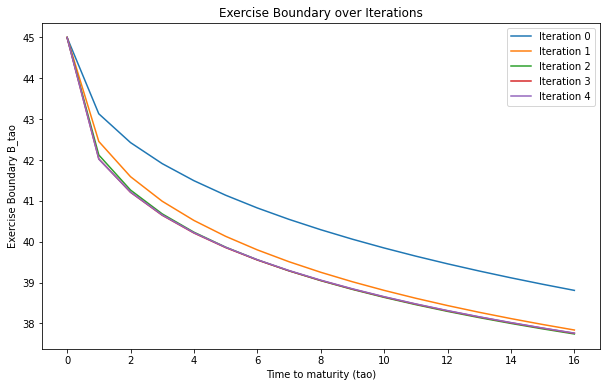

In [18]:
plot_B(hist_B)

The exercise boundary converged after four iterations

## Comparing with the Binomial Tree method for American Option Pricing

Binomial Tree is a common and efficient method used to price American Options. In the original paper A Simple Iterative Method for the Valuation of American Options, the result from binomial tree method was set as the benchmark case as a comparison to the iterative method. However, the author didn't give the implementation of Binomial Tree in the paper. In this project, I implement the binomial tree method as a comparison on both speed and accuracy.

The following code is a simple implementation of the Binomial Tree method for American put option

In [19]:
# Use the same parameters as before
S = 45
K = 45 
T = 0.5 
r = 0.05 
sigma = 0.2  

First, set up important parameters of the tree. Up factor represents the multiplier by which the asset's price increases in one time step, and down factor is the multiplier by which the asset's price decreases in one time step. The value is determined by the asset's volatility and time interval. The formula is given by $u = e^{\sigma\sqrt{\Delta T}}$ and $d = e^{-\sigma\sqrt{\Delta T}}$. In one time step, the price of the stock is either S*u if goes up or S*d if goes down.

In [20]:
N = 10000  # number of periods or number of time steps. Same as the paper

deltaT = T/N  # Delta t
u = np.exp(sigma * np.sqrt(deltaT))  # up factor
d = np.exp(-sigma * np.sqrt(deltaT))


In binomial tree method, we first obtain all possible stock prices at each time step given the current stock price S. This can be done by multiplying up factor or down factor each time. At maturity time T, there will be a list of possible stock prices $S_T$ given u and d. 

In [23]:
V = np.zeros(N + 1)  # vector to store values at each time step

# Use binomial theorem to get all terminal nodes on the tree
S_T = np.array([(S * u**j * d **(N - j)) for j in range(N + 1)]) 

S_T

array([3.24609369e-05, 3.25528802e-05, 3.26450840e-05, ...,
       6.20307792e+07, 6.22064771e+07, 6.23826727e+07])

Values of optios at T is $max(K-S_T,0)$, meaning that the option is either exercised when strike is higher than stock price or not exercised. We can use $V_{S,T}$ to recursively calculate $V_{S,T-\Delta t}$ by expressing it as an expectation: $V_{S,T-\Delta t}$ = $[V_{S_u,T} p + V_{S_d,T}(1-p)]e^{-r\Delta t}$. The same applies for all other time steps. By the end, $V_{S,0}$ represents the value of put option when $\tau = T$. We will compare this value to that obtained from the iterative method on the paper.

Remark: With no-arbitrage, for American options, the value will be $max(V_{S,t}, K-S_t)$, the second one being the intrinsic value of the put option at time t

In [24]:

p = (np.exp(r*deltaT) - d) / (u - d)  # risk neutral up probability
q = 1 - p  # risk neutral down probability

V[:] = np.maximum(K - S_T, 0)

for i in range(N-1,-1,-1):
    # N time intervals in total, so calculate recursively N times
    # the value vector is updated at each time step. Only the first i+1 value is valid after each update. 
    V[:-1] = np.exp(-r*deltaT)*(p * V[1:] + q * V[:-1])
    
    S_T = S_T * u  # calculate the price at the previous time step by backward 'going up' tree branches by one time step. Each time one value at the end will be invalid, but we can disregard that.

    V = np.maximum(V, K - S_T)

print("American put option price by Binomial Tree is: ", V[0])

American put option price by Binomial Tree is:  2.095030445179063


The result obtained by iterative method and binomial tree method are close, both at around 2.095. Although the two methods give similar prices, I still want to see whether they work in real life put options.

## Real-world example analysis
I took the stock price of AAPL as of Aug.21st and the implied volatiltiy, and I will check whether theoretical result is somewhere close to the price that the put was trading at today. For the purpose of illustration I pick the puts that expires that 9-13 (so T = 0.06 approximately). Other length of expiration may lead to different results, and that requires further analysis.

In [25]:
# Iterative method
S = 226.40
sigma = 0.215
K_lst = [220,225,230]
T = 0.06
r = 0.04

for K in K_lst:
    ip = IterativePricing(r, sigma, K, T, num_nodes= 17)
    for i in range(5):
        if i == 0:
            B = ip.first_iteration()
        else:
            B = ip.single_iteration(B)
    
    print(f"Put price of strike K = {K} by iterative method is {ip.calc_put_value(S,B)}")
    

Put price of strike K = 220 by iterative method is 2.0249024157608497
Put price of strike K = 225 by iterative method is 3.8585146868198317
Put price of strike K = 230 by iterative method is 6.525472068087436


In [30]:
# I wrote the binomial pricing in Binomial.py
from Binomial import binomial_option_pricing
for K in K_lst:
    print(f"Put price of strike K = {K} by Binomial Tree is: {binomial_option_pricing(T,sigma,r,N,K,S)}")

Put price of strike K = 220 by Binomial Tree is: 2.025499788353172
Put price of strike K = 225 by Binomial Tree is: 3.8583104863946454
Put price of strike K = 230 by Binomial Tree is: 6.525869253872257


Again, the two methods give nearly the same result. If we look at the spot prices that the puts are trading at today, they are not far from what we get theoretically! For reference, mid price for put at strike 220, 225 230 is 2.26, 3.84, 6.85 at close. URL: https://www.optionistics.com/quotes/stock-option-chains/AAPL

I also noticed that although the paper stated binomial tree method is time-consuming at N = 10000 level, my code was running with a fairly high speed. In contrast, the iterative method still needs more optimization, for example vectorizing the calculation, including some more difficult parts like Gaussian-quadrature and polynomial interpolation. The speed of the iterative method is not at its best potential, and this could be an object of further analysis.